<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/cstm_arch_1_soft_exudate_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2
import scipy
## Seeding 
seed = 2
random.seed = seed
#np.random.seed = seed
tf.seed = seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [4]:
def UNet_modular(depth=4,f=3,image_size=512):
    """ returns a modular code for the UNet multihead attention with
        deep supervision.
        depth is depth of model excluding bottleneck.
        f is no of filters in first layer.
        image_size is image pixel 
    """
    # define input container with 3 input channels
    input_channels=3
    inputs= keras.layers.Input((image_size, image_size, input_channels))
    pooled_out=inputs
    skip_memory=[]
    filters=[]
    for layer in range(depth):
      filters.append(f*2**layer)
    print(filters)

    for layer in range(depth):
      x,pooled_out=down_block(pooled_out,filters[layer])
      skip_memory.append(x)	

    # bottleneck_factor 
    bn_factor=2**depth
    upsample_out=bottleneck(pooled_out,f*bn_factor)
    upsample_memory=[upsample_out]
    for layer in range(depth):
      upsample_out=up_block(upsample_out,skip_memory[depth-1-layer],filters[depth-1-layer])
      upsample_memory.append(upsample_out)

    #up sample layer
    up=keras.layers.UpSampling2D((2,2))
    #create empty list for storing skip up samples 
    skip_up_list=[]
    # upsample the outputs of upsample layers stored in upsample_memory
    for i in range(depth):
      skip_up=upsample_memory[i]
      for j in range(depth-i):
        skip_up=up(skip_up)
      skip_up_list.append(skip_up)
    skip_up_list.append(upsample_memory[depth])
    deep_supervised = keras.layers.Concatenate()(skip_up_list)
    outputs=keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deep_supervised)
    model=keras.models.Model(inputs,outputs)
    return model


In [5]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))
 
print(len(train_data))


# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

54
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [6]:
def data_gen(x_path_list,y_path_list,batch_size=3):
  """
  Return batches of input image and segmentaion mask 
  """  
  train_batch = np.zeros(shape = (3, 512, 512, 3));
  train_label = np.zeros(shape = (3, 512, 512, 1));
  counter=0
  skipped=0
  while True :
    
    #image
    train_batch[0, :, :,:] = resize(imread(x_path_list[counter+skipped]), (512, 512))
    #label
    if x_path_list[counter+skipped][-6:-4]==y_path_list[counter][-9:-7]:
      img = cv2.cvtColor(imread(y_path_list[counter]), cv2.COLOR_BGRA2BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      train_label[0, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
      
      #flip
      train_batch[1, :, :,:]=np.flip(train_batch[0, :, :,:],axis=1)
      train_label[1, :, :,:]=np.flip(train_label[0, :, :,:],axis=1)
      #rotate
      train_batch[2, :, :,:]=np.rot90(np.rot90(train_batch[0, :, :,:]))
      train_label[2, :, :,:]=np.rot90(np.rot90(train_label[0, :, :,:]))
      train_batch/=255
      train_label[:,:,:,0]  = (train_label[:,:,:,0] - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
      mask = train_label[:,:,:,:] > 0.25
      train_label[mask] = 1.0
      train_label[~mask] = 0.0
      yield train_batch,train_label
      counter+=1
    else:
      skipped+=1
      
    
    if counter>=len(y_path_list):
      counter=0
      skipped=0
gen=data_gen(train_data,train_data_gt[0])

# load train data


In [7]:
#image load
train_batch_ = np.zeros(shape = (len(train_data), 512, 512, 3),dtype=int);
for file_index in range(0,len(train_data)):
  #print(file_index)
  # image
  img=imread(train_data[int(file_index)])
  clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
  #cl1 = clahe.apply(img[:,:,1])
  #cl0 = clahe.apply(img[:,:,0])
 # cl2 = clahe.apply(img[:,:,2])
  #train_batch_[file_index, :, :,:] = resize(img[:,220:3780,:], (512, 512))
  #train_batch_[file_index, :, :,1] = resize(cl1[:,220:3780], (512, 512))
  #train_batch_[file_index, :, :,0] = resize(cl0[:,220:3780], (512, 512))
  train_batch_[file_index, :, :,:] = resize(img[:,220:3780,:], (512, 512))
  
#label load
train_label_ = np.zeros(shape = (len(train_data_gt[3]), 512, 512, 1));
# but i am filing the test_label serially ie if one mask is not there i am not leaving that place balnk but filing the next mask in its place
for file_index in range(0,len(train_data_gt[3])):  
  img = cv2.cvtColor(imread(train_data_gt[3][file_index])[:,220:3780,:], cv2.COLOR_BGRA2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  train_label_[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)

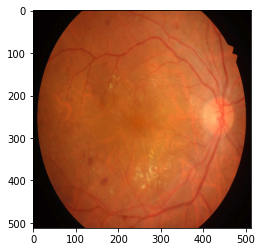

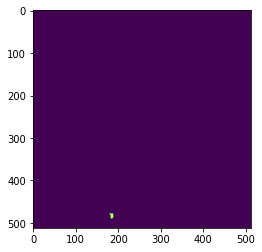

In [8]:
for i in range(1):
  plt.imshow(train_batch_[i][:,:,:])
  plt.show()
  plt.imshow(np.squeeze(train_label_[i]))
  plt.show()

In [ ]:
print(np.max(train_batch_),np.max(train_label_))

255 29.0


In [ ]:
print("image shape ",train_batch_.shape," label shape-",train_label_.shape)

image shape  (54, 512, 512, 3)  label shape- (26, 512, 512, 1)


In [9]:
ind=[]
for i in range(len(train_data_gt[3])):
  ind.append(int(train_data_gt[3][i][-9:-7]))
print(ind)
train_batch_soft=np.zeros(shape = (len(ind), 512, 512, 3),dtype=int);
for i,index in enumerate(ind):
  train_batch_soft[i,:,:,:]=train_batch_[index-1,:,:,:]
print(len(ind))

[3, 8, 13, 14, 17, 18, 19, 22, 23, 25, 30, 31, 32, 33, 35, 38, 39, 46, 47, 48, 49, 50, 51, 52, 53, 54]
26


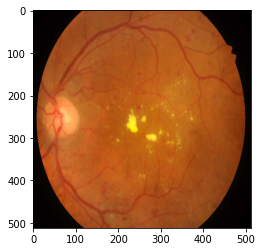

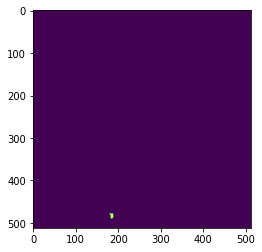

In [10]:
for i in range(1):
  plt.imshow(train_batch_soft[i][:,:,:])
  plt.show()
  plt.imshow(np.squeeze(train_label_[i]))
  plt.show()

In [ ]:
print(np.max(train_batch_soft),np.max(train_label_))

255 29.0


Now, data is in the train_batch_soft, train_label 

In [11]:
train_batch = np.zeros(shape = (len(train_batch_soft)*6, 512, 512, 3));
train_label = np.zeros(shape = (len(train_batch_soft)*6, 512, 512, 1));
rot=[-4,-3,3,4]
rot1=[-5,-2,2,5]
for file_index in range(0,len(train_batch_soft)*5,5):
    #print(file_index)
    # image
    train_batch[file_index, :, :,:] = train_batch_soft[int(file_index/5)]
    # label
    train_label[file_index, :, :,:] = train_label_[int(file_index/5)]
    #print(np.max(train_batch),np.max(train_label))
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #flip
    train_batch[file_index+2, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=0)
    train_label[file_index+2, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=0)
    #rotate
    train_batch[file_index+3, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+3, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))

    #random rotate
    ang=random.choice(rot)
    train_batch[file_index+4, :, :,:]=scipy.ndimage.rotate(train_batch[file_index, :, :,:],ang,reshape=False)
    train_label[file_index+4, :, :,:]=scipy.ndimage.rotate(train_label[file_index, :, :,:],ang,reshape=False)

    ang=random.choice(rot1)
    train_batch[file_index+5, :, :,:]=scipy.ndimage.rotate(train_batch[file_index, :, :,:],ang,reshape=False)
    train_label[file_index+5, :, :,:]=scipy.ndimage.rotate(train_label[file_index, :, :,:],ang,reshape=False)


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/np.max(train_batch)# - train_batch[:,:,:,0].min(axis=0)) / (train_batch[:,:,:,0].max(axis=0) - train_batch[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/np.max(train_batch)# - train_batch[:,:,:,1].min(axis=0)) / (train_batch[:,:,:,1].max(axis=0) - train_batch[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/np.max(train_batch)# - train_batch[:,:,:,2].min(axis=0)) / (train_batch[:,:,:,2].max(axis=0) - train_batch[:,:,:,2].min(axis=0)+1e-10)

train_label[:,:,:,0]  = (train_label[:,:,:,0])/np.max(train_label)# - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
mask = train_label[:,:,:,:] > 0.25
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(156, 512, 512, 3)
(156, 512, 512, 1)


In [ ]:
print(np.max(train_batch),np.max(train_label))

1.0 1.0


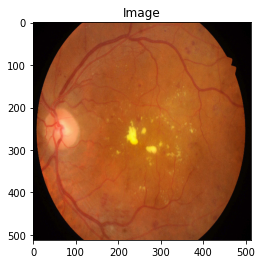

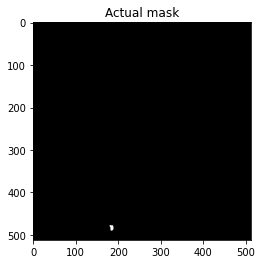

In [26]:
for i in range(0,5,5):
    plt.imshow(train_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(train_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

In [13]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice
def tversky(y_true, y_pred,smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.5
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

In [14]:
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(42)
depths=[4]
models=[]
histories=[]
#for f in [3,4,5]:
for depth in depths:
  opt=keras.optimizers.Adam(learning_rate = 0.0008,beta_1=0.5)
  model = UNet_modular(depth=depth,f=4) 
  model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])   
  #early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=5)
  #gen=data_gen(train_data,train_data_gt[3])
  #hist = model.fit(gen, steps_per_epoch=len(train_data_gt[3]), epochs = 200, verbose = 1, callbacks=[early_stopping], shuffle = 'batch')
  #hist = model.fit(train_generator, steps_per_epoch=train_label.shape[0]/4, epochs = 200, verbose = 1, callbacks=[early_stopping], shuffle = 'batch')
  hist = model.fit(x = train_batch, y = train_label, batch_size = 2, epochs = 30, verbose = 1, callbacks=[], validation_split = 8/150, shuffle = True)
  models.append(model)
  histories.append(hist) 

[4, 8, 16, 32]
Epoch 1/30
74/74 [==============================] - 76s 866ms/step - loss: 0.9861 - mean_io_u: 0.5012 - val_loss: 0.9999 - val_mean_io_u: 1.0000
Epoch 2/30
74/74 [==============================] - 60s 816ms/step - loss: 0.9524 - mean_io_u: 0.4893 - val_loss: 0.9998 - val_mean_io_u: 1.0000
Epoch 3/30
74/74 [==============================] - 61s 824ms/step - loss: 0.9074 - mean_io_u: 0.5072 - val_loss: 0.9993 - val_mean_io_u: 1.0000
Epoch 4/30
74/74 [==============================] - 62s 839ms/step - loss: 0.8613 - mean_io_u: 0.5181 - val_loss: 0.9969 - val_mean_io_u: 1.0000
Epoch 5/30
74/74 [==============================] - 63s 849ms/step - loss: 0.7547 - mean_io_u: 0.5888 - val_loss: 0.9802 - val_mean_io_u: 1.0000
Epoch 6/30
74/74 [==============================] - 63s 847ms/step - loss: 0.5419 - mean_io_u: 0.6482 - val_loss: 0.1617 - val_mean_io_u: 1.0000
Epoch 7/30
74/74 [==============================] - 63s 850ms/step - loss: 0.5313 - mean_io_u: 0.6334 - val_loss: 0

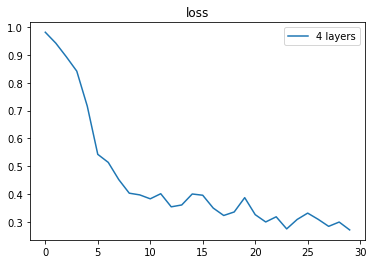

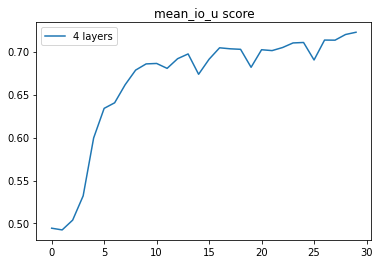

In [24]:
for i,hist in enumerate(histories):
  plt.plot(hist.history['loss'],label="{} layers".format(depths[i]))
plt.legend()
plt.title('loss')
plt.show()
for i,hist in enumerate(histories):
  plt.plot(hist.history['mean_io_u'],label="{} layers".format(depths[i]))
plt.legend()
plt.title('mean_io_u score')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve,precision_score,recall_score

In [16]:
def AUPR(labels,pred_prob):
  flatten_pred_prob=np.zeros(labels.shape).reshape(-1)
  flatten_labels=labels.reshape(-1)
  precision=[]
  recall=[]
  threshold=0
  for i in range(33):
    threshold=(8*i)/256
    #print(threshold)
    mask =  ( pred_prob.reshape(-1)> threshold+1e-6)
    #print(mask)
    flatten_pred_prob[mask] = 1
    flatten_pred_prob[~mask] = 0
    #print(flatten_pred_prob,flatten_labels)
    precision.append(precision_score(flatten_labels,flatten_pred_prob,labels=[0,1]))
    recall.append(recall_score(flatten_labels,flatten_pred_prob,labels=[0,1]))
    #print(precision[i],recall[i])
  return precision, recall

# Test data

In [17]:

# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))
    
print(len(test_data))
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

27
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


In [18]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    img=imread(test_data[int(file_index)])
    #clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    #cl1 = clahe.apply(img[:,:,1])
    #cl0 = clahe.apply(img[:,:,0])
    #cl2 = clahe.apply(img[:,:,2])
    #test_batch[file_index, :, :,0] = resize(cl0[:,220:3780], (512, 512))
    #test_batch[file_index, :, :,1] = resize(cl1[:,220:3780], (512, 512))
    test_batch[file_index, :, :,:] = resize(img[:,220:3780,:], (512, 512))

# Normalize
test_batch  = test_batch/255

In [19]:
test_label = np.zeros(shape = (len(test_data_gt[3]), 512, 512, 1));
# but i am filing the test_label serially ie if one mask is not there i am not leaving that place balnk but filing the next mask in its place
for file_index in range(0,len(test_data_gt[3])):  
  img = cv2.cvtColor(imread(test_data_gt[3][file_index]), cv2.COLOR_BGRA2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  test_label[file_index, :, :,:] = np.expand_dims(resize(img[:,220:3780], (512, 512)), axis = 2)
# scale to 0-1
test_label[:,:,:,0]  = (test_label[:,:,:,0])/np.max(test_label[:,:,:,0])# - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)
# binarize the masks
mask = test_label[:,:,:,:] > 0.3
test_label[mask] = 1
test_label[~mask] = 0

In [20]:
print(test_batch.shape)
print(test_label.shape)

(27, 512, 512, 3)
(14, 512, 512, 1)


In [21]:
ind=[]
for i in range(len(test_data_gt[3])):
  ind.append(int(test_data_gt[3][i][-9:-7])-54)
print(ind)
test_batch_soft=np.zeros(shape = (len(ind), 512, 512, 3));
for i,index in enumerate(ind):
  test_batch_soft[i,:,:,:]=test_batch[index-1,:,:,:]
print(len(ind))

[1, 2, 5, 6, 7, 10, 13, 14, 16, 17, 18, 19, 20, 21]
14


4 layers
train  0  test roc 0.9095058840854806
Train  F1 score: 0.000000 Test F1 score: 0.670258
Accuracy: 0.997699
natural threshold train AUPR 0  test AUPR 0.6773795435510227


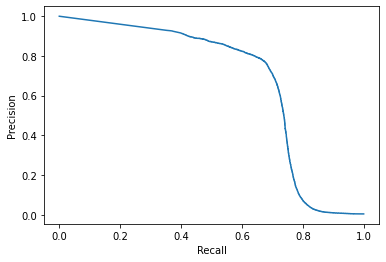

In [22]:
for i,model in enumerate(models):
  print(i+4, "layers")
  #generate the masks
  predicted_test_label=np.zeros(test_label.shape)
  for i in range(14):
    predicted_test_label[i]=model.predict(np.expand_dims(test_batch_soft[i],axis=0))
  
  
  # ROC
  test_auc = roc_auc_score(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
  print("train ",0," test roc",test_auc)

  # F1
  testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
  test_f1 = f1_score(testy, yhat_classes)
  #testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
  #train_f1 = f1_score(testy, yhat_classes)
  train_f1=0
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

  
  #accuracy
  accuracy = accuracy_score(testy, yhat_classes)
  print('Accuracy: %f' % accuracy)
  #AUPR
  
  test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("natural threshold train AUPR",train_auc," test AUPR",test_auc)
  #
  """test_aupr = AUPR(test_label,predicted_test_label)
  #train_aupr = precision_recall_curve(train_label.reshape(-1),predicted_train_label.reshape(-1))
  #train_auc=auc(train_aupr[1],train_aupr[0] )
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("train AUPR",train_auc," test AUPR",test_auc)
  """
  #plot Precision recall curve
  plt.plot(test_aupr[1],test_aupr[0])
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.show()
  #del predicted_test_label 

(512, 512, 1)


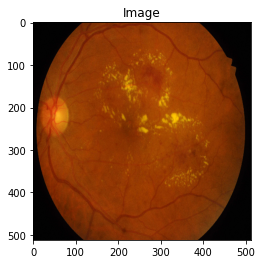

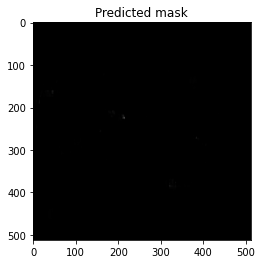

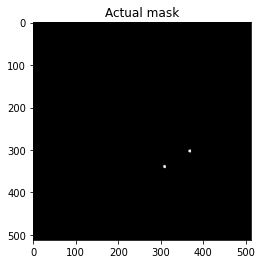

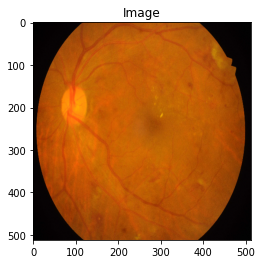

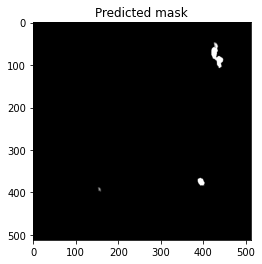

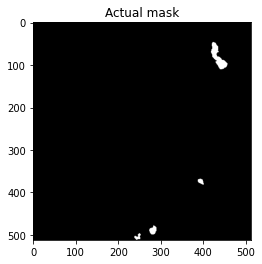

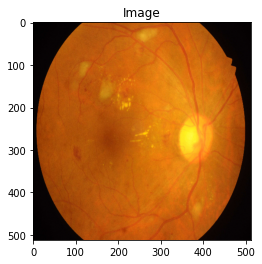

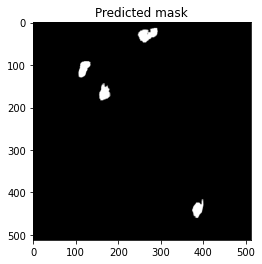

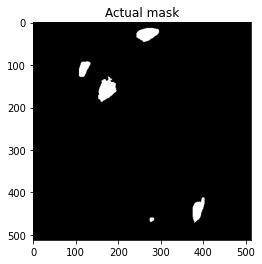

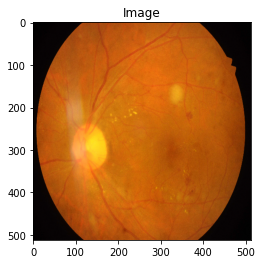

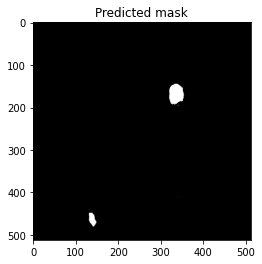

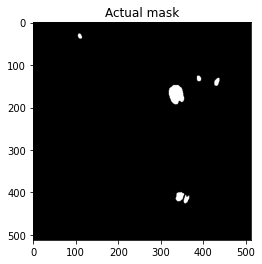

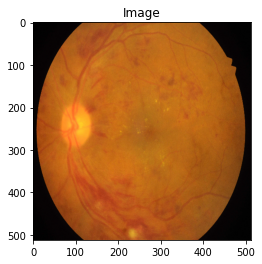

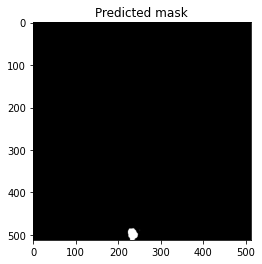

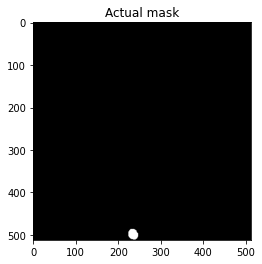

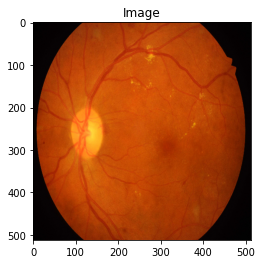

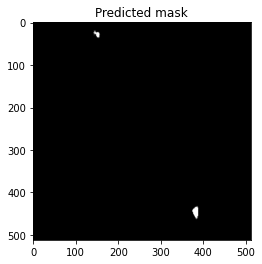

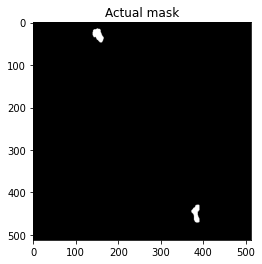

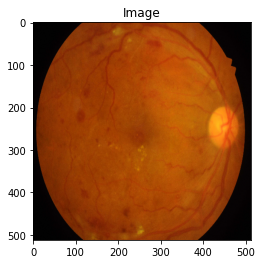

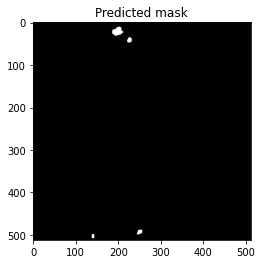

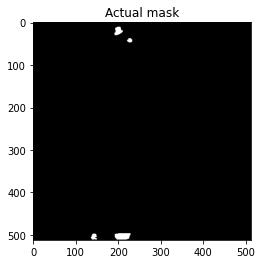

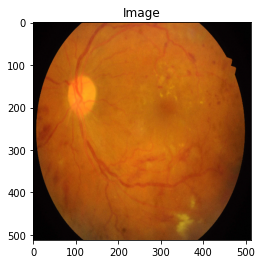

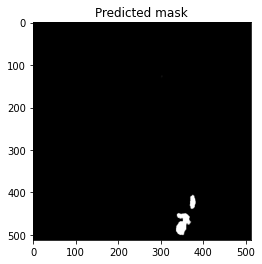

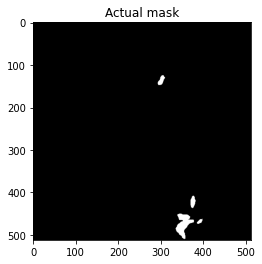

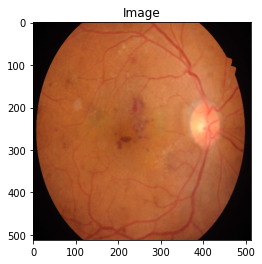

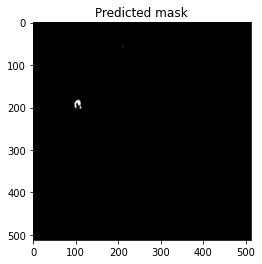

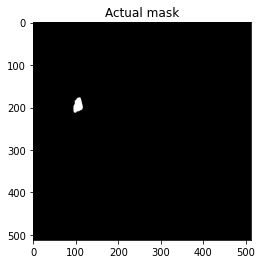

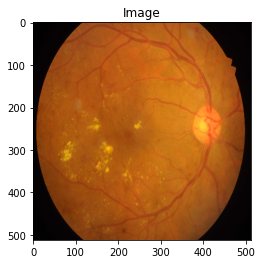

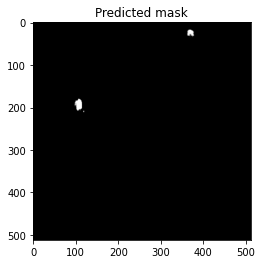

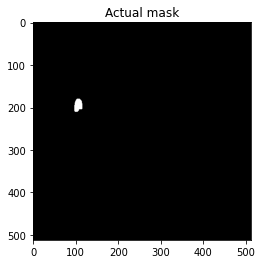

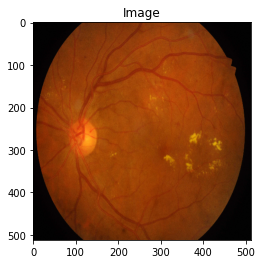

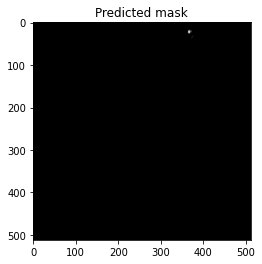

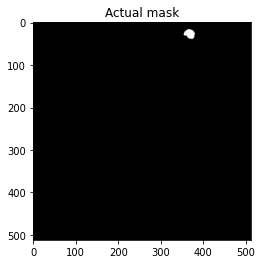

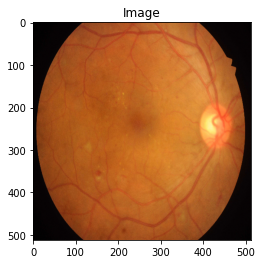

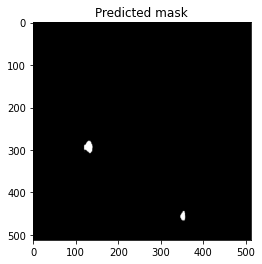

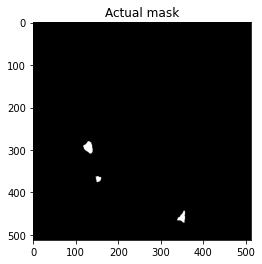

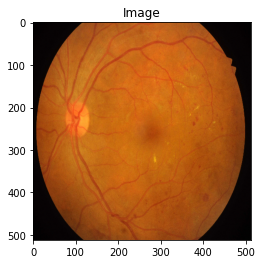

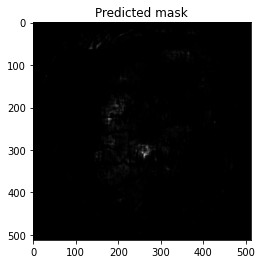

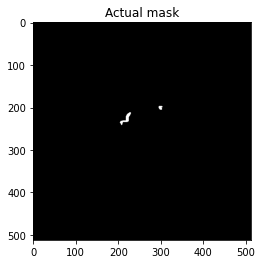

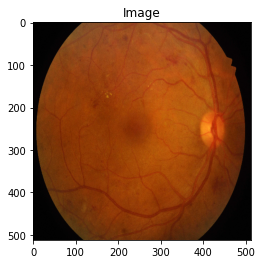

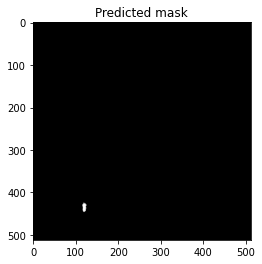

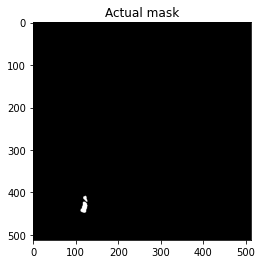

In [23]:
#predicted_test_label=models[2].predict(test_batch)
print(predicted_test_label[0].shape)
for i in range(14):
    plt.imshow(test_batch_soft[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict(brightness_range	=(.01,0.1),
    zoom_range=0.1,
    rotation_range=20,
    horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(train_batch_soft, augment=True, seed=1)
mask_datagen.fit(train_label, augment=True, seed=1)
image_generator = image_datagen.flow(
    train_batch_soft,batch_size=4,
    seed=1)
mask_generator = mask_datagen.flow(
    train_label,batch_size=4,
    seed=1)
train_generator = zip(image_generator, mask_generator)